# Spaceship game model fitting

In [1]:
import sys
sys.path.insert(0, '../code')
import dill
import re
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as T
import json
import os
from DMpy import DMModel, Parameter
from DMpy.utils import beta_response_transform
from DMpy.observation import softmax
import pandas as pd
import copy
from learning_models import *
from tqdm import tqdm
import seaborn as sns
import matplotlib
import matplotlib.font_manager as font_manager
prop = matplotlib.font_manager.FontProperties(fname="c:\\windows\\fonts\\nunitosans-light.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

pal = ['#4f4f4f', '#B80044', '#0e79b2']

# Get the data

In [83]:
model_data_path = '../Data/modelling_data'
qns = pd.read_csv('../Data/qns_full.csv')

dfs = []
count = 0

for i in tqdm([j for j in os.listdir(model_data_path) if 'combined' not in j]):
    temp_df = pd.read_csv(os.path.join(model_data_path, i))
    # Exclude subjects with too few trials or limited response variability, or we're missing questionnaire data for the subject
    if len(temp_df) == 269 and temp_df['Response'].std() > 0.05 and re.search('(?<=data_)[a-z0-9]+', i).group() in qns.Subject.tolist():
        dfs.append(temp_df)

data = pd.concat(dfs)
data.Response = 1 - data.Response
data['health'] = data['health'].fillna(-999)
data.to_csv(os.path.join(model_data_path, 'combined_modelling_data.csv'))
print "Number of subjects = {0}".format(len(data.Subject.unique()))
data.head()

100%|████████████████████████████████████████████████████████████████████████████████| 439/439 [00:11<00:00, 39.60it/s]
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


Number of subjects = 406


,Outcome,Outcome_2,Response,Subject,Unnamed: 0,health,score,trial
0,0,1,0.314883,data_54f74bc3fdf99b46ee467b27,0,0.7138,725.0,1
1,0,1,0.791115,data_54f74bc3fdf99b46ee467b27,1,0.5378,1125.0,2
2,1,1,0.776223,data_54f74bc3fdf99b46ee467b27,2,0.5619,1525.0,3
3,0,1,0.615480,data_54f74bc3fdf99b46ee467b27,3,0.2859,1925.0,4
4,0,1,0.840549,data_54f74bc3fdf99b46ee467b27,4,0.3099,2325.0,5


# Model-free analyses

In [84]:
change_data = data.copy().reset_index(drop=True)
change_data['change'] = change_data['Response'].diff()
change_data.loc[np.roll(change_data['health'], 1) == -999, 'change'] = np.nan

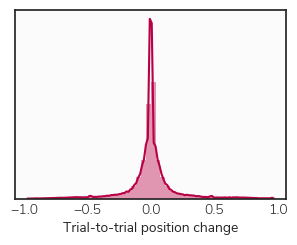

In [118]:
plt.figure(figsize=(3.5, 2.5), dpi=100)
sns.distplot(change_data.loc[~change_data['change'].isnull(), 'change'], color=pal[1])
plt.xlabel("Trial-to-trial position change")
plt.yticks([]);
# plt.ylabel("Density")


## Win-stay/lose-shift

In [123]:
ws_ls_df = dict(Subject=[], ls=[], ws=[])

for sub in tqdm(data['Subject'].unique()):
    temp_df = change_data[change_data['Subject'] == sub]
    ls = np.abs(temp_df.loc[((temp_df['Outcome'].shift(1) == 0) & (temp_df['Response'] >= 0.5)) | ((temp_df['Outcome_2'].shift(1) == 0) & (temp_df['Response'] < 0.5)), 'change']).mean()
    ws = np.abs(temp_df.loc[((temp_df['Outcome'].shift(1) == 1) & (temp_df['Response'] >= 0.5)) | ((temp_df['Outcome_2'].shift(1) == 1) & (temp_df['Response'] < 0.5)), 'change']).mean()
    ws_ls_df['Subject'].append(sub.replace('data_', ''))
    ws_ls_df['ls'].append(ls)
    ws_ls_df['ws'].append(ws)
    
ws_ls_df = pd.DataFrame(ws_ls_df)
ws_ls_df.to_csv('../Data/behavioural_measures.csv')
ws_ls_df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [00:09<00:00, 43.67it/s]


,Subject,ls,ws
0,54f74bc3fdf99b46ee467b27,0.107489,0.055495
1,550c3ed5fdf99b3039d68894,0.309865,0.083810
2,556db04dfdf99b26054b1768,0.267818,0.191603
3,55747e4afdf99b6752df4183,0.295057,0.096901
4,557c0bd8fdf99b120dc45dde,0.361900,0.226551


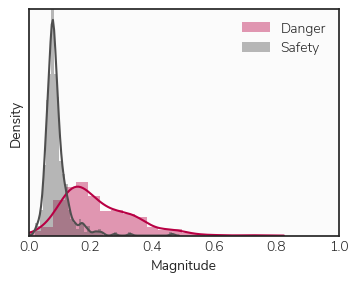

In [124]:
plt.figure(figsize=(4, 3), dpi=100)
sns.distplot(ws_ls_df['ls'], color=pal[1], label='Danger')
sns.distplot(ws_ls_df['ws'], color=pal[0], label='Safety')
plt.legend()
plt.xlim(0, 1)
plt.xlabel("Magnitude")
plt.ylabel("Density")
plt.yticks([]);
plt.savefig('position_changes.svg')

# Computational models

## Beta models

Asymmetric leaky beta (ALB) model - same as attention study, estimates for top and bottom separately and then combines with an additional bias parameter representing a general bias towards the top and bottom of the screen

### Basic model

No softmax or variance weighting of options.

In [3]:
value = Parameter('value', 'fixed', mean=0.5, dynamic=True)

alpha_0 = Parameter('alpha_0', 'fixed', lower_bound=1, upper_bound=10, mean=1, variance=100, dynamic=True)
beta_0 = Parameter('beta_0', 'fixed', lower_bound=1, upper_bound=10, mean=1, variance=5, dynamic=True)

alpha_1 = Parameter('alpha_1', 'fixed', lower_bound=1, upper_bound=10, mean=1, variance=100, dynamic=True)
beta_1 = Parameter('beta_1', 'fixed', lower_bound=1, upper_bound=10, mean=1, variance=5, dynamic=True)
 
# Decay rate, normally distributed between 0 and 1
decay = Parameter(r'decay', 'normal', lower_bound=0.01, upper_bound=0.9, mean=0.06, variance=100)

# Positive and negative weights for the asymmetric model, normally distributed between 0 and 1
tau_p = Parameter(r'tau_p', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=100)
tau_n = Parameter(r'tau_n', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=100)

# Weighting of the unchosen position
unchosen_p = Parameter(r'unchosen_p', 'normal', lower_bound=0.01, upper_bound=0.9, mean=0.5, variance=100)

# Define model
ALB_model = DMModel(ALB, [value, alpha_0, beta_0, alpha_0, beta_0, decay, tau_p, tau_n, unchosen_p], None, None,
                               name='ALB', logp_function='beta')

c:\users\toby\onedrive - university college london\dmpy\DMpy\model.py:1465: UserWarning: Parameter is specified as fixed, ignoring variance & bounds
  warnings.warn("Parameter is specified as fixed, ignoring variance & bounds")


### Model with softmax decision rule

In [4]:
# Softmax temperature
temperature = Parameter(r'temp', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=100^2)

# Define model
ALB_softmax_model = DMModel(ALB_softmax, [value, alpha_0, beta_0, alpha_1, beta_1, decay, tau_p, tau_n, unchosen_p, temperature], None, None,
                               name='ALB softmax', logp_function='beta')

### Model incorporating weighting by variance

In [5]:
# Variance weighting
var_weight = Parameter(r'var_weight', 'normal', lower_bound=0, upper_bound=0.9, mean=0, variance=100)

ALB_var_model = DMModel(ALB_var, [value, alpha_0, beta_0, alpha_1, beta_1, decay, tau_p, tau_n, unchosen_p, temperature, var_weight], None, None,
                               name='ALB variance', logp_function='beta')


### Model with UCB choice rule

In [6]:
ucb_weight = Parameter(r'ucb_weight', 'normal', lower_bound=0, upper_bound=0.9, mean=0, variance=100)

ALB_UCB_model = DMModel(ALB_UCB, [value, alpha_0, beta_0, alpha_1, beta_1, decay, tau_p, tau_n, unchosen_p, temperature, ucb_weight], None, None,
                               name='ALB UCB', logp_function='beta')


### Model incorporating weighting by health

In [7]:
# Health weighting
tau_p_w = Parameter(r'tau_p_w', 'normal', lower_bound=-0.9, upper_bound=0.9, mean=0, variance=100)
tau_n_w = Parameter(r'tau_n_w', 'normal', lower_bound=-0.9, upper_bound=0.9, mean=0, variance=100)
decay_w = Parameter(r'decay_w', 'normal', lower_bound=-0.9, upper_bound=0.9, mean=0, variance=100)

ALB_health_model = DMModel(ALB_softmax_health_weighting, [value, alpha_0, beta_0, alpha_1, beta_1, decay, tau_p, tau_n, unchosen_p, temperature,  tau_p_w, tau_n_w, decay_w], None, None,
                               name='ALB health', logp_function='beta')


### Model with choice stickiness

In [8]:
# Stickiness parameter
stickiness = Parameter(r'stickiness', 'normal', lower_bound=0.01, upper_bound=1, mean=1, variance=5)

# Define model
ALB_sticky_model = DMModel(sticky_ALB, [value, alpha_0, beta_0, alpha_1, beta_1, decay, tau_p, tau_n, unchosen_p, temperature, stickiness], None, None,
                               name='ALB sticky', logp_function='beta')

## Rescorla-Wagner family models

### Standard Rescorla-Wagner

In [9]:
# Value parameters
value = Parameter('value', 'fixed', mean=0.5, dynamic=True)
value_0 = Parameter('value_0', 'fixed', lower_bound=0, upper_bound=1, mean=0.5, variance=5, dynamic=True)
value_1 = Parameter('value_1', 'fixed', lower_bound=0, upper_bound=1, mean=0.5, variance=5, dynamic=True)

# Learning rate, normally distributed between 0 and 1
alpha = Parameter(r'alpha', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

# Initialise model
rescorla_wagner_model = DMModel(rescorla_wagner, [value, value_0, value_1, alpha, unchosen_p, temperature], None, None,
                               name='Rescorla wagner', logp_function='beta')

### Dual learning rate model

In [12]:
# Learning rates for dual learning rate model
alpha_n = Parameter(r'alpha_n', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)
alpha_p = Parameter(r'alpha_p', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

# Initialise dual learning rate model
dual_lr_model = DMModel(dual_lr, [value, value_0, value_1, alpha_n, alpha_p, unchosen_p, temperature], None, None,
                               name='Dynamic learning rate', logp_function='beta')

### Save the model instances to disk

In [11]:
models = [ALB_model, ALB_softmax_model, ALB_var_model, ALB_sticky_model, rescorla_wagner_model, dual_lr_model, ALB_health_model, ALB_UCB_model]

for m in tqdm(models):
    with open('../Data/models/{0}.pkl'.format(m.name.replace(' ', '_')), 'wb') as file:
        dill.dump(m, file)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 79.21it/s]


## Model fitting

_This cell isn't run here as it would be run in serial and take a while as a result_

Instead, the saved model instances are run in parallel (i.e. on a cluster) using the `fit_behavioural_model.sh` script in the code directory.

In [ ]:
for m in models[4:5]:
    print "Fitting {0}".format(m.name)
    
    # Variational
    m.fit(os.path.join(model_data_path, 'combined_modelling_data.csv'), model_inputs=['Outcome_2'], response_transform=beta_response_transform, 
          fit_method='variational', fit_kwargs={'n': 25000}, hierarchical=True, plot=False, suppress_table=True, fit_stats=True)
    
#     m.fit(os.path.join(model_data_path, 'combined_modelling_data.csv'), model_inputs=['Outcome_2'], response_transform=beta_response_transform, 
#           fit_method='variational', fit_kwargs=dict(n=300, method='svgd', inf_kwargs=dict(n_particles=500), obj_optimizer=pm.sgd(learning_rate=0.01)), 
#           hierarchical=True, plot=False, suppress_table=True, fit_stats=True, minibatch=True, minibatch_size=40)
    
    # MCMC
#     m.fit(os.path.join(model_data_path, 'combined_modelling_data.csv'), model_inputs=['Outcome_2'], response_transform=beta_response_transform, 
#           fit_method='mcmc', sample_kwargs=dict(njobs=1, draws=3000, tune=500), hierarchical=True, plot=False)
    


We can then reload these model instances as carry on as normal.

In [2]:
models = []

for m in tqdm([i for i in os.listdir('../Data/models') if '_fit' in i]):
    with open(os.path.join('../Data/models', m), 'rb') as f:
        models.append(dill.load(f))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:55<00:00, 15.57s/it]


## Model comparison

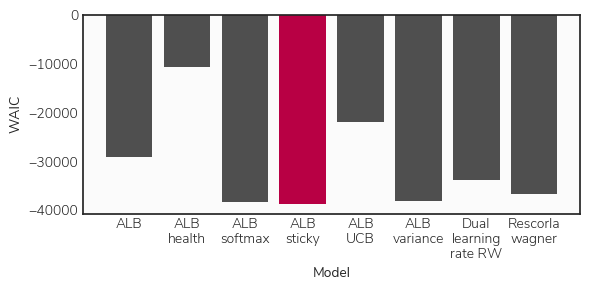

In [5]:
# Plot the WAIC scores for each model
plt.figure(figsize=(6, 3), dpi=100, facecolor='white')
waic_pal = [pal[0]] * len(models)
waics = np.array([m.WAIC for m in models])
winning_idx = np.where(waics == waics.min())[0][0]
waics[waics > 20000] = np.nan
waic_pal[winning_idx] = pal[1]
plt.bar([m.name.replace(' ', '\n').replace('Dynamic', 'Dual').replace('rate', 'rate RW') for m in models], waics, color=waic_pal)
plt.ylabel('WAIC')
plt.xlabel("Model")
plt.tight_layout()

# Save the figure
plt.savefig('../figures/model_comparison.svg', facecolor='#fbfbfb')
plt.savefig('../figures/model_comparison.png', facecolor='#fbfbfb')

### Simulate some data

Take estimated parameter values and use this to simulate some data.

In [4]:
sim, _ = models[winning_idx].simulate(response_variable='value', model_inputs=['Outcome_2'])

Simulating data from 406 sets of parameter values
Saving simulated results to 


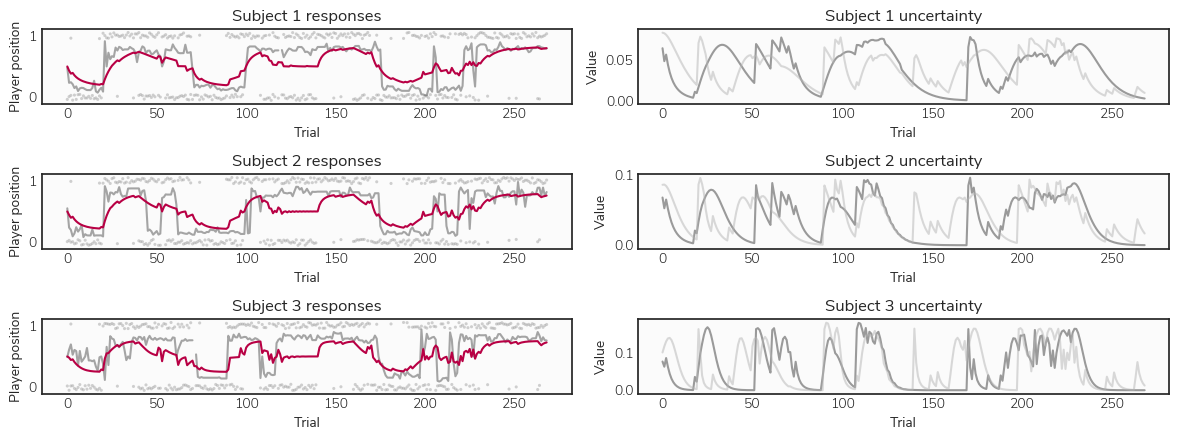

In [18]:
n_subs = 3

random_subs = np.random.choice(sim.results.Subject.unique(), n_subs, replace=False)

f, ax = plt.subplots(n_subs, 2, figsize=(12, 1.5 * n_subs), facecolor='white', dpi=100)

for n, sub in enumerate(random_subs):
    temp_data = sim.results[sim.results.Subject == sub].reset_index()
    ax[n, 0].plot(temp_data.True_response, color='#4f4f4f', alpha=0.5)
    ax[n, 0].plot(temp_data.Response, color='#B80044')
#     ax[n, 0].plot(temp_data['value_0'], color='#3a3a3a', alpha=0.5)
#     ax[n, 0].plot(temp_data['value_1'], color='#b5b5b5', alpha=0.5)
    ax[n, 0].set_ylabel("Player position")
    ax[n, 0].set_xlabel("Trial")
    ax[n, 0].set_title("Subject {0} responses".format(n+1))
    ax[n, 0].set_ylim(0, 1)
    
    ax[n, 1].plot(temp_data['var_0'], color='#3a3a3a', alpha=0.5)
    ax[n, 1].plot(temp_data['var_1'], color='#b5b5b5', alpha=0.5)
    ax[n, 1].set_title("Subject {0} uncertainty".format(n+1))
    ax[n, 1].set_ylabel("Value")
    ax[n, 1].set_xlabel("Trial")
    
    # Outcomes
    temp_data.loc[temp_data['Outcome'] == 0, 'Outcome'] = np.nan
    temp_data.loc[temp_data['sim_model_input_0'] == 0, 'sim_model_input_0'] = np.nan
    ax[n, 0].scatter(range(len(temp_data)), temp_data.Outcome + (np.random.random(len(temp_data)) - 0.5) * 0.1, 
                     edgecolors='none', facecolors='#a3a3a3', alpha=.5, s=5)
    ax[n, 0].scatter(range(len(temp_data)), temp_data.sim_model_input_0 - 1 + (np.random.random(len(temp_data)) - 0.5) * 0.1, 
                     edgecolors='none', facecolors='#a3a3a3', alpha=.5, s=5)
    
    ax[n, 0].set_ylim(-0.1, 1.1)

plt.tight_layout()

plt.savefig('../figures/ALB_sticky_simulated.png', facecolor='#fbfbfb')
plt.savefig('../figures/ALB_sticky_simulated.svg', facecolor='#fbfbfb')

## Parameter values

### Table showing parameter values

In [29]:
# ALB_var_model.parameter_table[[c for c in ALB_var_model.parameter_table.columns if 'Subject' in c or 'mean' in c]].head()
models[winning_idx].parameter_table.head()

,Subject,mean_decay,mean_stickiness,mean_tau_n,mean_tau_p,mean_temp,mean_unchosen_p,sd_decay,sd_stickiness,sd_tau_n,...,hpd_2.5_tau_n,hpd_2.5_tau_p,hpd_2.5_temp,hpd_2.5_unchosen_p,hpd_97.5_decay,hpd_97.5_stickiness,hpd_97.5_tau_n,hpd_97.5_tau_p,hpd_97.5_temp,hpd_97.5_unchosen_p
0,data_54f74bc3fdf99b46ee467b27,0.138480,0.887336,0.673527,0.262311,0.706316,0.703794,0.019825,0.109509,0.134939,...,0.432998,0.157767,0.608579,0.466225,0.173106,0.991737,0.876022,0.405352,0.822737,0.872734
1,data_550c3ed5fdf99b3039d68894,0.491344,0.859568,0.671984,0.161026,0.879332,0.716167,0.067730,0.104108,0.180563,...,0.295364,0.039888,0.761412,0.450554,0.607370,0.987147,0.917005,0.344384,0.969730,0.887064
2,data_556db04dfdf99b26054b1768,0.289550,0.820551,0.633116,0.335162,0.884472,0.754432,0.060188,0.100983,0.156076,...,0.344542,0.083368,0.748578,0.492973,0.380862,0.952970,0.937696,0.521329,0.978365,0.887014
3,data_55747e4afdf99b6752df4183,0.311022,0.910002,0.598118,0.232375,0.802363,0.709085,0.043002,0.073723,0.164784,...,0.321902,0.092014,0.678962,0.367937,0.415512,0.997315,0.945458,0.404186,0.906018,0.890218
4,data_557c0bd8fdf99b120dc45dde,0.208266,0.412125,0.380508,0.433006,0.912047,0.561109,0.050915,0.105463,0.164341,...,0.095839,0.168558,0.732183,0.217390,0.302774,0.630939,0.680473,0.719755,0.990073,0.883981


### Plot distributions of estimated values for each parameter

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


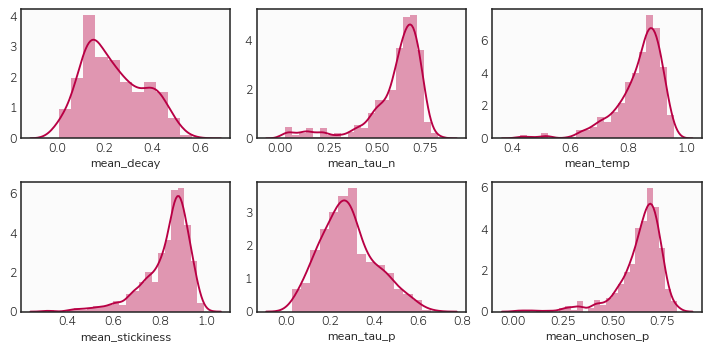

In [30]:
# parameters = [c for c in ALB_var_model.parameter_table.columns if 'mean' in c]
parameters = [c for c in models[winning_idx].parameter_table.columns if not 'Subject' in c and not 'error' in c and not 'sd_' in c and not 'hpd' in c and 'offset' not in c]

f, ax = plt.subplots(2, np.ceil(len(parameters) / 2.).astype(int), figsize=(8, 4), dpi=90, facecolor='white')

for n, p in enumerate(parameters):
    sns.distplot(models[winning_idx].parameter_table[p], ax=ax[n % 2, n / 2], color=pal[1])

plt.tight_layout();

## Plot $\tau$ values

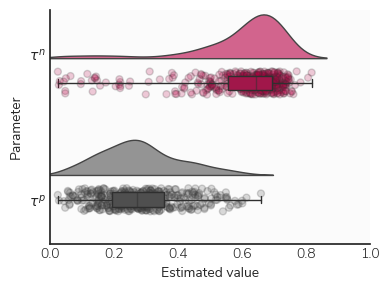

In [31]:
# Get tau values
tau_df = models[winning_idx].parameter_table[['mean_tau_p', 'mean_tau_n', 'Subject']].copy()
tau_df = pd.melt(tau_df, id_vars='Subject', value_vars=[i for i in tau_df.columns if 'mean' in i],
                                                        value_name='Estimated value', var_name='Parameter')
tau_df['Parameter'] = tau_df['Parameter'].str.replace('mean_tau_p', r'$\tau^p$')
tau_df['Parameter'] = tau_df['Parameter'].str.replace('mean_tau_n', r'$\tau^n$')

# Violin plot - this uses a fork of Seaborn that is capable of doing half-violin plots
plt.figure(figsize=(4, 3), dpi=100, facecolor='white')
violin = sns.violinplot(x='Estimated value', y="Parameter", data=tau_df, inner=None,
              jitter=True, color=".7", lwidth=0, width=0.6, offset=0.17, cut=1,
              linewidth=1, alpha=0.6, palette=pal, zorder=19);
for n, i in enumerate([i for i in violin.collections if isinstance(i, matplotlib.collections.PolyCollection)]):            
    plt.setp(i, facecolor=matplotlib.colors.colorConverter.to_rgba(pal[n], alpha=0.6))
    plt.setp(i, edgecolor=matplotlib.colors.colorConverter.to_rgba('#444444', alpha=1))

# Plot individual data points
sp = sns.stripplot(x='Estimated value', y="Parameter", data=tau_df, 
              jitter=0.08, linewidth=1, alpha=0.2, palette=pal, zorder=1);

# Boxplot
ax = sns.boxplot(x='Estimated value', y="Parameter", data=tau_df, 
                 palette=pal, whis=np.inf, linewidth=1, zorder=0,
           width=0.1, boxprops={"zorder":10, 'alpha':1}, whiskerprops={'zorder':10, 'alpha':1}, 
                 medianprops={'zorder':11, 'alpha':0.5});
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
    
# Set up axes
plt.xlabel("Estimated value");
plt.ylabel("Parameter");
plt.yticks([0, 0.8])
plt.ylim([-0.3, 1.3])
plt.yticks([0, 1], [r'$\tau^p$', r'$\tau^n$'])
plt.xlim(0, 1)

# Make it look nice
sns.despine()
plt.tight_layout()

# Save
plt.savefig('../figures/tau_values.svg', facecolor='#fbfbfb')
plt.savefig('../figures/tau_values.png', facecolor='#fbfbfb')

## Save data for use in further analyses

Here we take estimated parameter values for each subject and calculate average value and uncertainty estimates for both positions on the screen

In [32]:
# param_values = ALB_var_model.parameter_table[[c for c in ALB_var_model.parameter_table.columns if 'Subject' in c or 'mean' in c]].copy()
param_values = models[winning_idx].parameter_table.copy()
param_values.loc[:, 'mean_uncertainty'] = np.nan
param_values.loc[:, 'mean_value'] = np.nan

# Get mean value and uncertainty estimates
for sub in tqdm(param_values.Subject):
    temp_data = sim.results[sim.results.Subject == sub].reset_index()
    temp_data.loc[:, 'pe_0'] = temp_data['o'] - temp_data['value_0']
    temp_data.loc[:, 'pe_1'] = temp_data['o2'] - temp_data['value_1']
    param_values.loc[param_values.Subject == sub, 'mean_value'] = np.hstack([temp_data['value_0'], temp_data['value_1']]).mean()
    param_values.loc[param_values.Subject == sub, 'mean_uncertainty'] = np.hstack([temp_data['var_0'], temp_data['var_1']]).mean()
    param_values.loc[param_values.Subject == sub, 'mean_pe'] = np.hstack([temp_data['pe_0'], temp_data['pe_1']]).mean()

param_values.Subject = param_values.Subject.str.replace('data_', '')

100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [00:34<00:00, 11.90it/s]


In [33]:
param_values.head()

,Subject,mean_decay,mean_stickiness,mean_tau_n,mean_tau_p,mean_temp,mean_unchosen_p,sd_decay,sd_stickiness,sd_tau_n,...,hpd_2.5_unchosen_p,hpd_97.5_decay,hpd_97.5_stickiness,hpd_97.5_tau_n,hpd_97.5_tau_p,hpd_97.5_temp,hpd_97.5_unchosen_p,mean_uncertainty,mean_value,mean_pe
0,54f74bc3fdf99b46ee467b27,0.138480,0.887336,0.673527,0.262311,0.706316,0.703794,0.019825,0.109509,0.134939,...,0.466225,0.173106,0.991737,0.876022,0.405352,0.822737,0.872734,0.042307,0.574976,0.114615
1,550c3ed5fdf99b3039d68894,0.491344,0.859568,0.671984,0.161026,0.879332,0.716167,0.067730,0.104108,0.180563,...,0.450554,0.607370,0.987147,0.917005,0.344384,0.969730,0.887064,0.043978,0.608287,0.073869
2,556db04dfdf99b26054b1768,0.289550,0.820551,0.633116,0.335162,0.884472,0.754432,0.060188,0.100983,0.156076,...,0.492973,0.380862,0.952970,0.937696,0.521329,0.978365,0.887014,0.040630,0.654498,0.018364
3,55747e4afdf99b6752df4183,0.311022,0.910002,0.598118,0.232375,0.802363,0.709085,0.043002,0.073723,0.164784,...,0.367937,0.415512,0.997315,0.945458,0.404186,0.906018,0.890218,0.047874,0.614040,0.062540
4,557c0bd8fdf99b120dc45dde,0.208266,0.412125,0.380508,0.433006,0.912047,0.561109,0.050915,0.105463,0.164341,...,0.217390,0.302774,0.630939,0.680473,0.719755,0.990073,0.883981,0.040086,0.800924,-0.137355


And save to a csv file

In [34]:
param_values.to_csv('../Data/subject_param_values.csv')

In [35]:
sim.results.to_csv('../Data/simulated_data.csv')

In [37]:
len(sim.results) / 269.

406.0